# News Article Similarity Analysis

This project clusters news articles based on their semantic similarity using NLP techniques. It uses GloVe embeddings to convert text to vectors, PCA for dimensionality reduction, K-Means for clustering, and word clouds for visualization. The project was implemented as a learning exercise to demonstrate skills in text processing, clustering, and visualization.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from wordcloud import WordCloud
from collections import Counter
import urllib.request
import zipfile
import os

# Download NLTK resources
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)

# Create plots directory for saving visualizations
if not os.path.exists('plots'):
    os.makedirs('plots')

## 1. Load Dataset

Load the news articles dataset from a public URL and display basic information.

In [2]:
# Load dataset
print("Loading dataset...")
try:
    url = 'https://raw.githubusercontent.com/mage-ai/datasets/refs/heads/master/news_articles.csv'
    df = pd.read_csv(url)
    print("\nDataset loaded successfully!")
    print("\nFirst 5 rows of dataset:")
    print(df.head())
    print("\nDataset info:")
    print(df.info())
except Exception as e:
    print(f"Error loading dataset: {e}")
    exit()

# Handle missing values
print("\nHandling missing values...")
df['description'] = df['description'].fillna('')
print("Number of missing values in description column:", df['description'].isna().sum())

Loading dataset...

Dataset loaded successfully!

First 5 rows of dataset:
           topic                                           headline  \
0  entertainment  Will Smith Joins Diplo And Nicky Jam For The 2...   
1  entertainment    Hugh Grant Marries For The First Time At Age 57   
2  entertainment  Morgan Freeman 'Devastated' That Sexual Harass...   
3  entertainment  What To Watch On Amazon Prime That’s New This ...   
4  entertainment  Mike Myers Reveals He'd 'Like To' Do A Fourth ...   

            author                                               link  \
0    Andy McDonald  https://www.huffingtonpost.com/entry/will-smit...   
1       Ron Dicker  https://www.huffingtonpost.com/entry/hugh-gran...   
2       Ron Dicker  https://www.huffingtonpost.com/entry/morgan-fr...   
3  Todd Van Luling  https://www.huffingtonpost.com/entry/amazon-pr...   
4    Andy McDonald  https://www.huffingtonpost.com/entry/mike-myer...   

                                         description publis

## 2. Preprocess Text

Clean the text in the 'description' column by lowercasing, removing special characters, numbers, and stopwords, and store the result in 'cleaned_description'.

In [3]:
# Get list of stopwords
stop_words = set(stopwords.words('english'))

# Text cleaning function
def preprocess_text(text):
    """
    Preprocess text by lowercasing, removing special characters, numbers, and stopwords.

    Args:
        text (str): Input text to preprocess

    Returns:
        str: Cleaned text
    """
    if not isinstance(text, str) or pd.isna(text):
        return ''
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply preprocessing
print("\nPreprocessing text...")
df['cleaned_description'] = df['description'].apply(preprocess_text)
print("\nFirst 3 samples of original and cleaned descriptions:")
print(df[['description', 'cleaned_description']].head(3))


Preprocessing text...

First 3 samples of original and cleaned descriptions:
                                         description  \
0                           Of course it has a song.   
1  The actor and his longtime girlfriend Anna Ebe...   
2  "It is not right to equate horrific incidents ...   

                                 cleaned_description  
0                                        course song  
1  actor longtime girlfriend anna eberstein tied ...  
2  right equate horrific incidents sexual assault...  


## 3. Download and Load GloVe Embeddings

Download GloVe embeddings, unzip them, and load the 100-dimensional vectors into a dictionary.

In [4]:
# Download and unzip GloVe embeddings
print("\nDownloading GloVe embeddings...")
url = 'https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip'
output = os.path.join(os.getcwd(), 'glove.6B.zip')
urllib.request.urlretrieve(url, output)

print("Unzipping GloVe embeddings...")
with zipfile.ZipFile('./glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall('./glove')

# Load GloVe embeddings
def load_glove_embeddings(glove_path):
    """
    Load GloVe word embeddings from a file.

    Args:
        glove_path (str): Path to GloVe file

    Returns:
        dict: Dictionary of word embeddings
    """
    embeddings = {}
    try:
        with open(glove_path, 'r', encoding='utf-8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                vector = np.array(values[1:], dtype='float32')
                embeddings[word] = vector
        print("GloVe embeddings loaded successfully!")
        return embeddings
    except FileNotFoundError:
        print(f"Error: GloVe file not found at {glove_path}")
        exit()
    except Exception as e:
        print(f"Error loading GloVe embeddings: {e}")
        exit()

glove_path = "glove/glove.6B.100d.txt"
glove_embedding = load_glove_embeddings(glove_path)


Unzipping GloVe embeddings...
GloVe embeddings loaded successfully!


## 4. Convert Text to GloVe Vectors

Convert cleaned text to 100-dimensional GloVe vectors by averaging word embeddings.

In [5]:
# Convert text to GloVe vectors
def text_to_vector(text, embeddings, dim=100):
    """
    Convert text to a GloVe vector by averaging word embeddings.

    Args:
        text (str): Input text
        embeddings (dict): GloVe embeddings dictionary
        dim (int): Dimension of GloVe vectors

    Returns:
        np.array: Averaged vector for the text
    """
    if not text or not isinstance(text, str):
        return np.zeros(dim)
    words = text.split()
    vectors = [embeddings.get(word, np.zeros(dim)) for word in words]
    if vectors and any(np.any(v != 0) for v in vectors):
        return np.mean(vectors, axis=0)
    return np.zeros(dim)

# Apply vectorization
print("\nConverting texts to GloVe vectors...")
df['glove_vector'] = df['cleaned_description'].apply(lambda x: text_to_vector(x, glove_embedding))
print("\nFirst 5 GloVe vectors:")
for i, (content, vector) in enumerate(zip(df['cleaned_description'].head(), df['glove_vector'].head())):
    print(f"Description {i+1}:")
    print(f"Cleaned Description: {content[:50]}...")
    print(f"First 5 values: {vector[:5]}...")


Converting texts to GloVe vectors...

First 5 GloVe vectors:
Description 1:
Cleaned Description: course song...
First 5 values: [-0.142866  0.002452  0.57652   0.047115  0.40146 ]...
Description 2:
Cleaned Description: actor longtime girlfriend anna eberstein tied knot...
First 5 values: [ 0.06428084 -0.20556878 -0.010587   -0.06554887  0.13560955]...
Description 3:
Cleaned Description: right equate horrific incidents sexual assault mis...
First 5 values: [ 0.054433   -0.01141746  0.19488525 -0.23279582 -0.27712438]...
Description 4:
Cleaned Description: theres great miniseries joining week...
First 5 values: [ 0.0309464   0.2023232   0.292542   -0.189569    0.04549321]...
Description 5:
Cleaned Description: myers kids may pushing new powers film anyone...
First 5 values: [ 0.15048063 -0.03074763  0.4015145  -0.19838123  0.03591875]...


## 5. Dimensionality Reduction with PCA

Reduce GloVe vectors to 2D using PCA for visualization and save the scatter plot.


Converting to 2D with PCA...
Shape of GloVe matrix: (55335, 100)
Shape after PCA: (55335, 2)


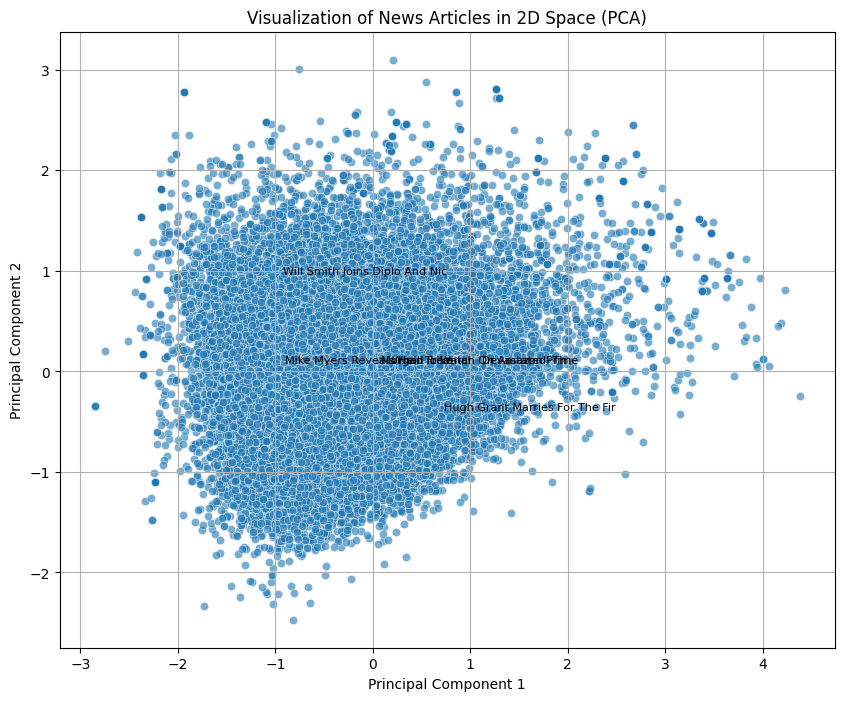

In [6]:
# Dimensionality reduction with PCA
print("\nConverting to 2D with PCA...")
try:
    X = np.vstack(df['glove_vector'])
    print(f"Shape of GloVe matrix: {X.shape}")
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X)
    print(f"Shape after PCA: {X_pca.shape}")
    df['pca_x'] = X_pca[:, 0]
    df['pca_y'] = X_pca[:, 1]
except Exception as e:
    print(f"Error in PCA transformation: {e}")
    exit()

# Plot and save PCA scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x=df['pca_x'], y=df['pca_y'], alpha=0.6)
plt.title('Visualization of News Articles in 2D Space (PCA)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
if 'headline' in df.columns:
    for i in range(min(5, len(df))):
        plt.annotate(df['headline'].iloc[i][:30], (df['pca_x'].iloc[i], df['pca_y'].iloc[i]), fontsize=8)
plt.grid(True)
plt.savefig('plots/pca_scatter.png', bbox_inches='tight')
plt.show()

## 6. K-Means Clustering

Apply K-Means clustering to group articles into 4 clusters and visualize the results.


Applying K-Means clustering...

Cluster distribution:
cluster
2    16728
3    16640
0    15061
1     6906
Name: count, dtype: int64


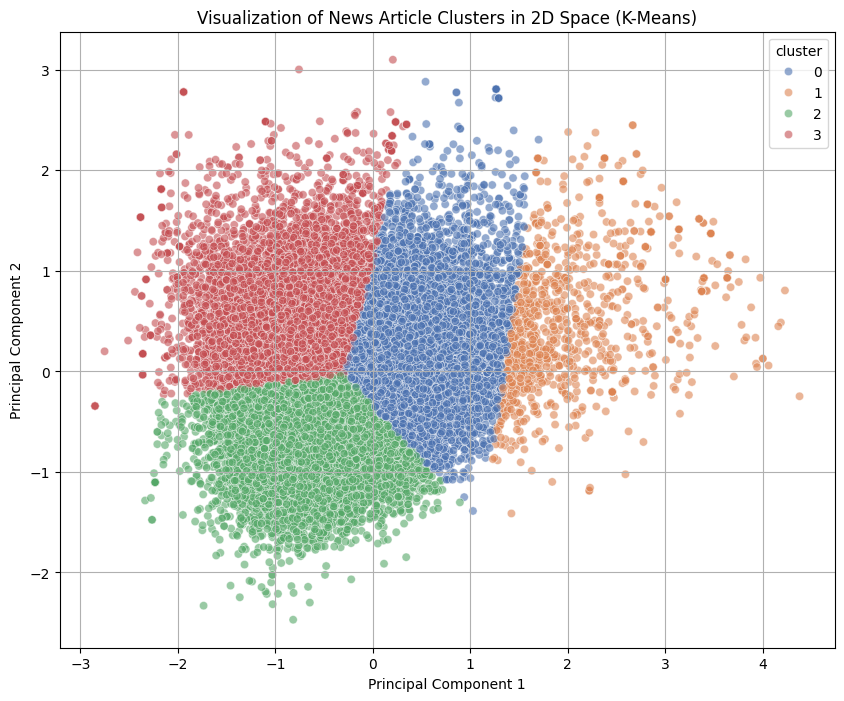

In [7]:
# Apply K-Means clustering
print("\nApplying K-Means clustering...")
kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster'] = kmeans.fit_predict(X_pca)
print("\nCluster distribution:")
print(df['cluster'].value_counts())

# Plot and save clustered scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(x=df['pca_x'], y=df['pca_y'], hue=df['cluster'], palette='deep', alpha=0.6)
plt.title('Visualization of News Article Clusters in 2D Space (K-Means)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.savefig('plots/clustered_scatter.png', bbox_inches='tight')
plt.show()

## 7. Generate Word Clouds

Generate word clouds for each cluster to visualize key themes and save them as images.


Generating word clouds for each cluster...

Generating word cloud for cluster 0...
Word cloud for cluster 0 saved to plots/wordcloud_cluster_0.png


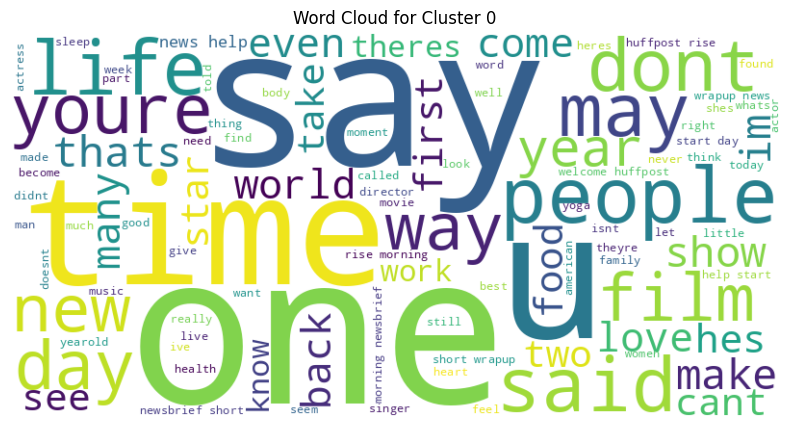


Generating word cloud for cluster 1...
Word cloud for cluster 1 saved to plots/wordcloud_cluster_1.png


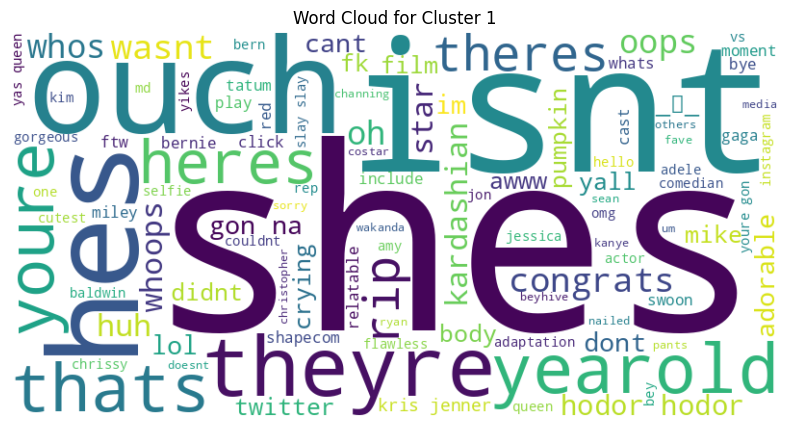


Generating word cloud for cluster 2...
Word cloud for cluster 2 saved to plots/wordcloud_cluster_2.png


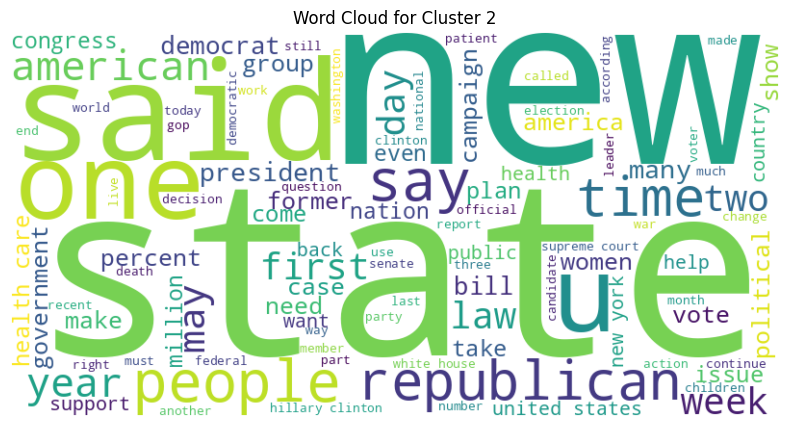


Generating word cloud for cluster 3...
Word cloud for cluster 3 saved to plots/wordcloud_cluster_3.png


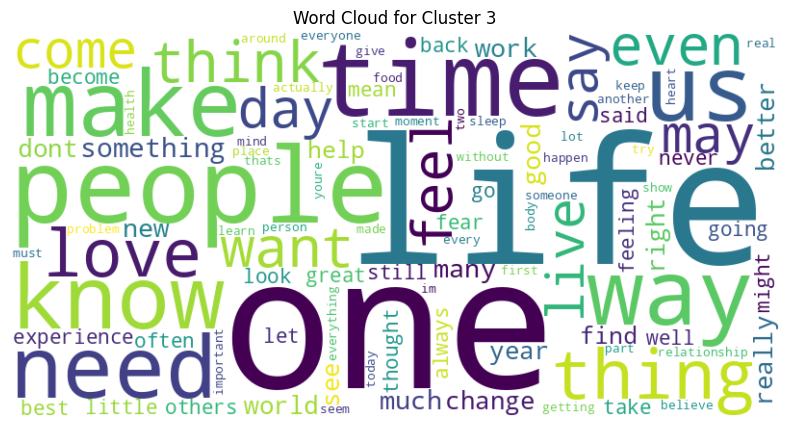


Top words in each cluster:

Cluster 0:
[('new', 631), ('one', 592), ('like', 542), ('us', 477), ('dont', 464), ('youre', 438), ('day', 433), ('time', 405), ('said', 372), ('people', 369)]

Cluster 1:
[('shes', 23), ('isnt', 19), ('ouch', 18), ('youre', 17), ('hes', 16), ('theyre', 16), ('yearold', 15), ('thats', 14), ('heres', 12), ('theres', 11)]

Cluster 2:
[('new', 1400), ('us', 1088), ('said', 1070), ('one', 912), ('health', 891), ('people', 836), ('state', 792), ('would', 779), ('president', 716), ('years', 672)]

Cluster 3:
[('life', 1863), ('one', 1767), ('people', 1664), ('us', 1622), ('time', 1620), ('like', 1425), ('get', 1272), ('make', 1120), ('know', 1077), ('way', 1013)]


In [8]:
# Generate word clouds for each cluster
def generate_wordcloud(texts, cluster_id, save_path=None):
    """
    Generate a word cloud for a given cluster.

    Args:
        texts (Series): Text data for the cluster
        cluster_id (int): ID of the cluster
        save_path (str): Directory to save the word cloud image (optional)
    """
    combined_text = ' '.join(text for text in texts if isinstance(text, str) and text.strip())
    if not combined_text:
        print(f"Error: No valid text found for cluster {cluster_id}!")
        return
    wordcloud = WordCloud(width=800, height=400,
                          background_color='white',
                          min_font_size=10,
                          max_words=100).generate(combined_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Cluster {cluster_id}')
    plt.axis('off')
    if save_path:
        plt.savefig(f"{save_path}/wordcloud_cluster_{cluster_id}.png", bbox_inches='tight')
        print(f"Word cloud for cluster {cluster_id} saved to {save_path}/wordcloud_cluster_{cluster_id}.png")
    plt.show()
    plt.close()

# Generate word clouds
print("\nGenerating word clouds for each cluster...")
unique_clusters = df['cluster'].unique()
for cluster_id in sorted(unique_clusters):
    print(f"\nGenerating word cloud for cluster {cluster_id}...")
    cluster_texts = df[df['cluster'] == cluster_id]['cleaned_description']
    generate_wordcloud(cluster_texts, cluster_id, save_path='plots')

# Show top words for each cluster
print("\nTop words in each cluster:")
for cluster_id in sorted(unique_clusters):
    cluster_texts = df[df['cluster'] == cluster_id]['cleaned_description']
    combined_text = ' '.join(text for text in cluster_texts if isinstance(text, str))
    words = combined_text.split()
    word_freq = Counter(words).most_common(10)
    print(f"\nCluster {cluster_id}:")
    print(word_freq)